In [1]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
from numpy.linalg import norm, LinAlgError
from sklearn.model_selection import train_test_split
from tensorly import unfold

# ---------------- Basic configuration ---------------- ### change to the new path
IMG_PATH = Path("/home/ysui8/yangsuienv/tensoritr/ADNI haimati image/yalingeneticsleft19.txt")
COV_PATH = Path("/home/ysui8/yangsuienv/tensoritr/ADNI haimati image/covariate_df.txt")

SEED        = 7817       # random seed for reproducibility
N_TRAIN     = 600
N_TEST      = 126
STANDARDIZE = False     

np.random.seed(SEED)


## Preprocessing covariates and image data

In [2]:
def read_and_convert_images(txt_path: Path, rows: int = 100, cols: int = 150) -> np.ndarray:
    with open(txt_path, "r") as f:
        lines = f.readlines()
    mats = [np.reshape(list(map(float, ln.split())), (rows, cols), order="F") for ln in lines]
    return np.stack(mats, axis=0)

# Load images and covariates
image_array = read_and_convert_images(IMG_PATH)       # (N, 100, 150)
covariate_df = pd.read_csv(COV_PATH, sep="\t")

# Drop rows with NaNs in covariates and mirror deletions in images
na_idx = covariate_df[covariate_df.isna().any(axis=1)].index
cov_df = covariate_df.drop(index=na_idx).reset_index(drop=True)
image_array_cleaned = np.delete(image_array, na_idx, axis=0)

print("Clean DataFrame shape:", cov_df.shape)
print("Clean image array shape:", image_array_cleaned.shape)

# APOE4 dummy variables
cov_df.loc[:, "APOE4_1"] = (cov_df["APOE4"] == 1).astype(int)
cov_df.loc[:, "APOE4_2"] = (cov_df["APOE4"] == 2).astype(int)

# W columns (p = 10)
w_cols = [
    "Gender","Handedness","Marital Status1","Marital Status2","Marital Status3",
    "Education length","Retirement status","Age","APOE4_1","APOE4_2"
]

# Convert to numpy
W_full = cov_df.loc[:, w_cols].to_numpy(dtype=float)                 # (N, p)
Y_full = cov_df.loc[:, "MMSE"].to_numpy(dtype=float).reshape(-1, 1)  # (N, 1)
A_full = cov_df.loc[:, "treatment"].to_numpy(dtype=float)            # (N,)
N, p   = W_full.shape
H_img, W_img = image_array_cleaned.shape[1:]


Clean DataFrame shape: (726, 27)
Clean image array shape: (726, 100, 150)


In [3]:
idx_train, idx_test = train_test_split(
    np.arange(N), train_size=N_TRAIN, test_size=N_TEST, shuffle=True, random_state=SEED
)

W_tr, W_te = W_full[idx_train], W_full[idx_test]
X_tr, X_te = image_array_cleaned[idx_train], image_array_cleaned[idx_test]
A_tr, A_te = A_full[idx_train], A_full[idx_test]
Y_tr, Y_te = Y_full[idx_train], Y_full[idx_test]

if STANDARDIZE:
    # Covariates: standardize using train-set statistics
    W_mu_tr = W_tr.mean(axis=0, keepdims=True)
    W_sd_tr = W_tr.std(axis=0, ddof=0, keepdims=True).clip(1e-8, None)
    W_tr_n = (W_tr - W_mu_tr) / W_sd_tr
    W_te_n = (W_te - W_mu_tr) / W_sd_tr

    # Images: per-pixel standardization using train-set statistics
    X_mu_tr = X_tr.mean(axis=0, keepdims=True)
    X_sd_tr = X_tr.std(axis=0, ddof=0, keepdims=True).clip(1e-8, None)
    X_tr_n = (X_tr - X_mu_tr) / X_sd_tr
    X_te_n = (X_te - X_mu_tr) / X_sd_tr
else:
    # No standardization: just copy
    W_tr_n, W_te_n = W_tr.copy(), W_te.copy()
    X_tr_n, X_te_n = X_tr.copy(), X_te.copy()


In [4]:
ones_tr = np.ones((W_tr_n.shape[0], 1))
ones_te = np.ones((W_te_n.shape[0], 1))

A1_tr   = A_tr.reshape(-1, 1)                 # A * 1 (treatment intercept part)
A1_te   = A_te.reshape(-1, 1)
AW_tr   = A_tr.reshape(-1, 1) * W_tr_n        # A * W (treatment-covariate interactions)
AW_te   = A_te.reshape(-1, 1) * W_te_n

# Final design matrix (two intercepts; θ dimension = 2*(p+1))
C_train = np.hstack([ones_tr, W_tr_n, A1_tr, AW_tr])   # (n_tr, 2 + 2p)
C_test  = np.hstack([ones_te, W_te_n, A1_te, AW_te])   # (n_te, 2 + 2p)

# Image-treatment interaction term: AX = A * X
AX_tr = X_tr_n * A_tr[:, None, None]
AX_te = X_te_n * A_te[:, None, None]

print(f"C_train shape: {C_train.shape}  (expect ({N_TRAIN}, {2+2*p}))")
print(f"C_test  shape: {C_test.shape}   (expect ({N_TEST},  {2+2*p}))")


C_train shape: (600, 22)  (expect (600, 22))
C_test  shape: (126, 22)   (expect (126,  22))


## Testing RMSE without image data

In [5]:
def ridge_eval(y_train, C_train, y_test, C_test, lambda_reg=1e-5, return_theta_as_column=True):
    y_train = np.asarray(y_train, dtype=float).reshape(-1)
    y_test  = np.asarray(y_test,  dtype=float).reshape(-1)
    C_train = np.asarray(C_train, dtype=float)
    C_test  = np.asarray(C_test,  dtype=float)

    n_train, d = C_train.shape
    assert C_test.shape[1] == d

    AtA = C_train.T @ C_train + lambda_reg * np.eye(d)
    Aty = C_train.T @ y_train
    try:
        theta = np.linalg.solve(AtA, Aty)  # (d,)
    except LinAlgError:
        theta, *_ = np.linalg.lstsq(AtA, Aty, rcond=None)

    y_pred = C_test @ theta
    resid  = y_test - y_pred
    mse  = float(np.mean(resid**2))
    rmse = float(np.sqrt(mse))
    mae  = float(np.mean(np.abs(resid)))
    ss_tot = float(np.sum((y_test - y_test.mean())**2)) + 1e-12
    r2 = 1.0 - float(np.sum(resid**2)) / ss_tot

    if return_theta_as_column:
        theta = theta.reshape(-1, 1)
        y_pred = y_pred.reshape(-1, 1)
    return mse, rmse, theta, mae, r2, y_pred

mse, rmse, theta_lin, mae, r2, yhat_lin = ridge_eval(
    y_train=Y_tr, C_train=C_train,
    y_test=Y_te,  C_test=C_test,
    lambda_reg=1e-5
)
print(f"[Baseline Linear] MSE={mse:.6f} | RMSE={rmse:.6f} | MAE={mae:.6f} | R^2={r2:.4f}")


[Baseline Linear] MSE=19.019690 | RMSE=4.361157 | MAE=3.363527 | R^2=0.0521


## define the value function

In [6]:
def _scalar(x):
    return float(np.asarray(x).reshape(()))

def pi_hat(n, X_test, c1_test, H, CH, theta):
    """
    Policy value under optimal deterministic rule:
      If (linear gain + image gain) > 0, assign treatment; otherwise no treatment.

    Inputs
    -------
    n        : number of test samples
    X_test   : test images, shape (n, p1, p2)
    c1_test  : [1, W] for test set, shape (n, p+1)
    H        : baseline image coefficient (no treatment)
    CH       : treatment-related image coefficient
    theta    : stacked linear coefficients, shape (2*(p+1), 1) or (2*(p+1),);
               layout: [alpha1_0, alpha1; alpha2_0, alpha2]

    Returns
    -------
    Scalar mean policy value.
    """
    p1 = c1_test.shape[1]           # p+1
    theta = np.asarray(theta).reshape(-1, 1)

    theta_base  = theta[:p1]        # (p+1, 1)
    theta_treat = theta[p1:p1+p1]   # (p+1, 1)

    base_lin  = c1_test @ theta_base              # (n, 1)
    gain_lin  = c1_test @ theta_treat             # (n, 1)
    base_img  = np.array([_scalar(np.sum(X_test[i] * H))  for i in range(n)]).reshape(-1, 1)
    gain_img  = np.array([_scalar(np.sum(X_test[i] * CH)) for i in range(n)]).reshape(-1, 1)

    gain = gain_lin + gain_img
    val  = base_lin + base_img + np.maximum(gain, 0.0)
    return _scalar(np.mean(val))


def pi_random(n, X_test, c1_test, H, CH, theta, seed=2024):
    """
    Randomized policy values:
      For prob in {0.1, ..., 0.9}, independently assign treatment ~ Bernoulli(prob),
      compute resulting average outcome.

    Returns
    -------
    List of mean values for each randomization probability.
    """
    p1 = c1_test.shape[1]
    theta = np.asarray(theta).reshape(-1, 1)
    theta_base  = theta[:p1]
    theta_treat = theta[p1:p1+p1]

    base_lin  = c1_test @ theta_base
    gain_lin  = c1_test @ theta_treat
    base_img  = np.array([_scalar(np.sum(X_test[i] * H))  for i in range(n)]).reshape(-1, 1)
    gain_img  = np.array([_scalar(np.sum(X_test[i] * CH)) for i in range(n)]).reshape(-1, 1)

    y0 = base_lin + base_img
    y1 = base_lin + base_img + gain_lin + gain_img

    rng = np.random.default_rng(seed)
    means = []
    for prob in np.arange(0.1, 1.0, 0.1):
        flip = rng.binomial(1, prob, size=n).reshape(-1, 1)
        V = (1 - flip) * y0 + flip * y1
        means.append(_scalar(np.mean(V)))
    return means


def pi_notensor(y_train, C_train, n_test, c1_test):
    """
    Linear-only baseline (no image terms).

    Steps
    -----
    1. Fit ridge regression on:
           C_train = [1, W, A*1, A*W]
    2. Decompose theta into:
           theta_base  = [alpha1_0, alpha1]
           theta_treat = [alpha2_0, alpha2]
    3. For test [1, W] = c1_test:
           base = c1_test · theta_base
           gain = c1_test · theta_treat
           value = base + max(gain, 0)

    Returns
    -------
    Scalar mean policy value.
    """
    p1 = c1_test.shape[1]              # p+1
    lam = 1e-5

    y_vec = y_train.reshape(-1)
    AtA = C_train.T @ C_train + lam * np.eye(C_train.shape[1])
    Aty = C_train.T @ y_vec
    try:
        theta = np.linalg.solve(AtA, Aty).reshape(-1, 1)
    except LinAlgError:
        theta, *_ = np.linalg.lstsq(AtA, Aty, rcond=None)
        theta = theta.reshape(-1, 1)

    theta_base  = theta[:p1]
    theta_treat = theta[p1:p1+p1]

    base_lin = c1_test @ theta_base
    gain_lin = c1_test @ theta_treat
    val = base_lin + np.maximum(gain_lin, 0.0)
    return _scalar(np.mean(val))


## Define TITR function

In [7]:
def ADMM(y, X, B0, lambd, gamma=1, tol=1e-4, iter_max=10):
    """
    Solve:
        min_B  (1/2) || y - X vec(B) ||^2 + lambd * ||B||_1
    using an ADMM scheme with proximal SVT-like projection.
    Uses solve instead of explicit inverse for numerical stability.
    """
    B = B0.copy()
    P = B0.copy()
    dim1, rank1 = B0.shape

    beta_b = B0.flatten().reshape((-1, 1))
    beta   = beta_b.copy()
    E   = np.zeros((dim1, rank1))
    eta = np.zeros((dim1 * rank1, 1))
    u   = np.zeros((len(y), 1))
    r   = np.zeros((len(y), 1))
    I   = np.eye(dim1 * rank1)

    tolerance1 = 1.0
    iter1 = 0
    while tolerance1 >= tol and iter1 <= iter_max:
        # soft-threshold update for beta
        beta = beta_b + eta / gamma
        beta = np.maximum(beta - lambd / gamma, 0) - np.maximum(-beta - lambd / gamma, 0)

        # update r
        r = gamma * (y - (X @ beta_b).reshape((-1, 1)) + u / gamma) / (gamma + 2)

        # inner loop for beta_b
        tolerance2 = 1.0
        iter2 = 0
        beta_b0 = beta_b.copy()
        A_sys = X.T @ X + 2 * I
        while tolerance2 >= 1e-3 and iter2 <= 50:
            rhs = (
                X.T @ (u / gamma + y - r)
                - eta / gamma
                + beta
                + P.flatten().reshape(-1, 1)
                - E.flatten().reshape(-1, 1) / gamma
            )
            beta_bb = np.linalg.solve(A_sys, rhs)

            Bb = beta_bb.reshape((dim1, rank1))
            U, _, Vt = np.linalg.svd(Bb + E / gamma, full_matrices=False)
            P = U @ Vt
            E = E + gamma * (Bb - P)

            tolerance2 = norm(beta_bb - beta_b0)
            beta_b0 = beta_bb
            iter2 += 1

        beta_b = beta_bb
        u   = u   + gamma * (y - X @ beta_b - r)
        eta = eta + gamma * (beta_b - beta)

        B = beta_b.reshape((dim1, rank1))
        tolerance1 = norm(B - B0, ord='fro')
        B0 = B.copy()
        iter1 += 1

    return B


def tensor_r_lasso(
    y, X, AX, c,
    y_test, X_test, AX_test, c_test,
    R1, R2, AR1, AR2, lambda1, lambdaa, seed, MAX_ITER1
):
    """
    Fit tensor-based model:
        E[Y | W, X, A] = <X, H> + c·theta + <AX, CH>

    where:
      - c = [1, W, A*1, A*W], so theta has dimension 2*(p+1)
        and is interpreted as:
            theta_base  = [alpha1_0, alpha1]
            theta_treat = [alpha2_0, alpha2]
      - H  captures baseline image effect
      - CH captures treatment-related image effect (interacts with AX)

    Training uses observed A through AX and A*W terms in c.
    Policy evaluation (pi_hat / pi_random) uses the fitted (H, CH, theta)
    and counterfactual decision rules, not the observed A.
    """
    import time
    np.random.seed(seed)
    time_start = time.time()

    n, p1, p2 = X.shape
    _, d = c.shape

    assert d == 2 * (p + 1), "Design matrix C must have 2*(p+1) columns for [[1,W], A·[1,W]]."

    # initialization
    B1 = np.random.normal(0, 0.01, p1 * R1).reshape((p1, R1))
    B2 = np.random.normal(0, 0.01, p2 * R2).reshape((p2, R2))
    C1 = np.random.normal(0, 0.01, p1 * AR1).reshape((p1, AR1))
    C2 = np.random.normal(0, 0.01, p2 * AR2).reshape((p2, AR2))
    G  = np.random.normal(0, 0.01, size=(R1, R2))
    AG = np.random.normal(0, 0.01, size=(AR1, AR2))
    theta = np.random.normal(0, 0.01, d).reshape((d, 1))

    # initial H, CH and contributions
    H  = np.tensordot(np.tensordot(G,  B1, axes=(0, 1)), B2, axes=(0, 1))
    CH = np.tensordot(np.tensordot(AG, C1, axes=(0, 1)), C2, axes=(0, 1))

    w1 = np.array([_scalar(np.sum(X[i]  * H))  for i in range(n)]).reshape(-1, 1)
    w2 = np.array([_scalar(np.sum(AX[i] * CH)) for i in range(n)]).reshape(-1, 1)

    y0 = y.copy()
    loss_test = 0.0

    for t in range(MAX_ITER1):
        # ----- update B1 -----
        yt = y0 - c @ theta
        y_res = yt - w2
        B1_old = B1.copy()

        X1 = np.zeros((n, R1 * p1))
        G0 = unfold(G, 0)
        for i in range(n):
            M0 = unfold(X[i], 0)
            X1[i, :] = np.ravel(M0 @ B2 @ G0.T)
        lam2 = lambda1 * norm(B2, ord=1)
        B1 = ADMM(y_res, X=X1, B0=B1_old, lambd=lam2, gamma=1)

        # ----- update B2 -----
        B2_old = B2.copy()
        X2 = np.zeros((n, R2 * p2))
        G1 = unfold(G, 1)
        for i in range(n):
            M1 = unfold(X[i], 1)
            X2[i, :] = np.ravel(M1 @ B1 @ G1.T)
        lam2 = lambda1 * norm(B1, ord=1)
        B2 = ADMM(y_res, X=X2, B0=B2_old, lambd=lam2, gamma=1)

        # ----- update G via least squares -----
        XG = np.zeros((n, R1 * R2))
        for i in range(n):
            Xvec = np.ravel(unfold(X[i], 0))
            XG[i, :] = (np.kron(B1, B2).T @ Xvec)
        bG, *_ = np.linalg.lstsq(XG, y_res.reshape(-1), rcond=None)
        G = bG.reshape((R1, R2))

        # recompute H and w1
        H_old = H.copy()
        H = np.tensordot(np.tensordot(G, B1, axes=(0, 1)), B2, axes=(0, 1))
        w1 = np.array([_scalar(np.sum(X[i] * H)) for i in range(n)]).reshape(-1, 1)
        y_res = yt - w1

        # ----- update C1 -----
        C1_old = C1.copy()
        X1 = np.zeros((n, AR1 * p1))
        AG0 = unfold(AG, 0)
        for i in range(n):
            M0 = unfold(AX[i], 0)
            X1[i, :] = np.ravel(M0 @ C2 @ AG0.T)
        lam2 = lambdaa * norm(C2, ord=1)
        C1 = ADMM(y_res, X=X1, B0=C1_old, lambd=lam2, gamma=1)

        # ----- update C2 -----
        C2_old = C2.copy()
        X2 = np.zeros((n, AR2 * p2))
        AG1 = unfold(AG, 1)
        for i in range(n):
            M1 = unfold(AX[i], 1)
            X2[i, :] = np.ravel(M1 @ C1 @ AG1.T)
        lam2 = lambdaa * norm(C1, ord=1)
        C2 = ADMM(y_res, X=X2, B0=C2_old, lambd=lam2, gamma=1)

        # ----- update AG via least squares -----
        XAG = np.zeros((n, AR1 * AR2))
        for i in range(n):
            AXvec = np.ravel(unfold(AX[i], 0))
            XAG[i, :] = (np.kron(C1, C2).T @ AXvec)
        bAG, *_ = np.linalg.lstsq(XAG, y_res.reshape(-1), rcond=None)
        AG = bAG.reshape((AR1, AR2))

        # ----- update CH and theta (ridge on c) -----
        CH_old = CH.copy()
        CH = np.tensordot(np.tensordot(AG, C1, axes=(0, 1)), C2, axes=(0, 1))
        w2 = np.array([_scalar(np.sum(AX[i] * CH)) for i in range(n)]).reshape(-1, 1)
        y_fit = y0 - w1 - w2

        theta_old = theta.copy()
        lam_reg = 1e-5
        CtC = c.T @ c + lam_reg * np.eye(c.shape[1])
        Cty = c.T @ y_fit
        try:
            theta = np.linalg.solve(CtC, Cty)
        except LinAlgError:
            theta, *_ = np.linalg.lstsq(CtC, Cty, rcond=None)

        # ----- train loss -----
        res_train = y0 - (c @ theta) - w1 - w2
        loss_train = float((norm(res_train) ** 2) / n)

        # ----- test loss -----
        n_test = y_test.shape[0]
        w1_te = np.array([_scalar(np.sum(X_test[i] * H))  for i in range(n_test)]).reshape(-1, 1)
        w2_te = np.array([_scalar(np.sum(AX_test[i] * CH)) for i in range(n_test)]).reshape(-1, 1)
        res_test = y_test - (c_test @ theta) - w1_te - w2_te
        loss_test_new = float((norm(res_test) ** 2) / n_test)

        # early stopping: roll back if test loss increases
        if (t > 0) and (loss_test_new > loss_test):
            H = H_old
            CH = CH_old
            theta = theta_old
            break
        loss_test = loss_test_new

        # ----- policy values on test -----
        c1_test = c_test[:, :p+1]  # [1,W] block
        V_hat      = pi_hat(n_test, X_test, c1_test, H, CH, theta)
        V_random   = pi_random(n_test, X_test, c1_test, H, CH, theta)
        V_notensor = pi_notensor(y0, c, n_test, c1_test)
        # (Optional) print for monitoring:
        # print(t, loss_train, loss_test, V_hat, float(np.mean(V_random)), V_notensor)

    elapsed = time.time() - time_start
    return elapsed, loss_train, loss_test, H, CH, theta, V_hat, V_random, V_notensor

## Imaging and covariate coefficients

In [8]:
time_cost, loss_tr, loss_te, H, CH, theta, V_hat, V_random, V_notensor = tensor_r_lasso(
    y=Y_tr,            # training y (not centered; two intercepts already in design)
    X=X_tr_n,          # training images
    AX=AX_tr,          # A*X (training)
    c=C_train,         # training design matrix: [1, W, A*1, A*W]

    y_test=Y_te,       # test y
    X_test=X_te_n,     # test images
    AX_test=AX_te,     # A*X (test)
    c_test=C_test,     # test design matrix: [1, W, A*1, A*W]

    R1=2, R2=2,
    AR1=2, AR2=2,
    lambda1=0.1,
    lambdaa=1,
    seed=1998,
    MAX_ITER1=30
)

V_random_mean = float(np.mean(V_random))
print(
    f"[Tensor] time={time_cost:.2f}s | loss_train={loss_tr:.6f} | loss_test={loss_te:.6f} | "
    f"V_hat={V_hat:.6f} | V_random_mean={V_random_mean:.6f} | V_notensor={V_notensor:.6f}"
)


[Tensor] time=22.81s | loss_train=10.723745 | loss_test=15.394663 | V_hat=26.233019 | V_random_mean=25.096862 | V_notensor=25.892034


In [9]:
theta

array([[-7.72534267],
       [-0.66980593],
       [ 0.65552163],
       [-0.52283459],
       [-0.13395958],
       [ 2.06733408],
       [ 0.12608301],
       [-0.98428376],
       [ 0.1048531 ],
       [-1.44101087],
       [-2.05963216],
       [ 6.60778256],
       [ 0.22009088],
       [ 0.41163291],
       [ 0.95174127],
       [ 1.64892386],
       [ 0.94771887],
       [ 0.06748684],
       [ 0.35563471],
       [-0.13024643],
       [ 0.63282005],
       [-1.58131545]])

## Identify the top-3 strong signal subregions and plot

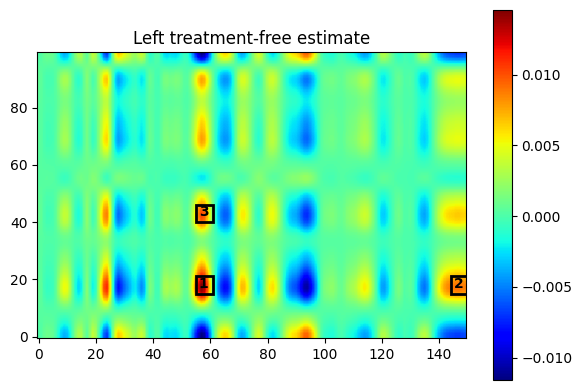

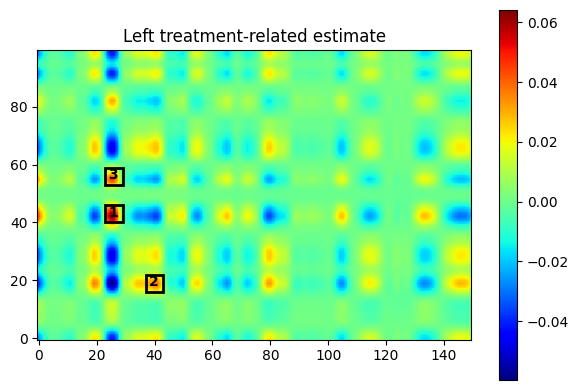

Top-3 A1 blocks: [{'r0': 15, 'c0': 55, 'r1': 21, 'c1': 61, 'mean': 0.01046998500374448}, {'r0': 15, 'c0': 144, 'r1': 21, 'c1': 150, 'mean': 0.008380198797235228}, {'r0': 40, 'c0': 55, 'r1': 46, 'c1': 61, 'mean': 0.007368428167920721}]
Top-3 A2 blocks: [{'r0': 40, 'c0': 23, 'r1': 46, 'c1': 29, 'mean': 0.037684383090519996}, {'r0': 16, 'c0': 37, 'r1': 22, 'c1': 43, 'mean': 0.025902021572202016}, {'r0': 53, 'c0': 23, 'r1': 59, 'c1': 29, 'mean': 0.022727100131509782}]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ===== save coefficient maps =====
# A1 = treatment-free image coefficient (H)
# A2 = treatment-related image coefficient (CH)
A1 = H
A2 = CH

np.savetxt("left_H.txt",  A1)
np.savetxt("left_CH.txt", A2)

# ---------- helpers ----------

def _integral_image(M):
    """Integral image with zero padding on top/left."""
    S = np.pad(M, ((1, 0), (1, 0)), mode="constant")
    return S.cumsum(0).cumsum(1)

def _window_sum(S, r0, c0, k):
    """Sum over [r0:r0+k, c0:c0+k) using integral image S."""
    r1, c1 = r0 + k, c0 + k
    return S[r1, c1] - S[r0, c1] - S[r1, c0] + S[r0, c0]

def top_k_patches_sliding_mean(M, k=6, K=3, min_gap=5):
    """
    Sliding-window k×k over M (stride=1), pick top-K patches by signed mean.
    After picking one, suppress neighbors within `min_gap` in (r0,c0) space.
    Returns list of dicts: {r0,c0,r1,c1,mean}.
    """
    Htot, Wtot = M.shape
    if Htot < k or Wtot < k:
        return []

    S = _integral_image(M)
    Hk, Wk = Htot - k + 1, Wtot - k + 1
    means = np.empty((Hk, Wk), dtype=float)
    area = float(k * k)

    for r0 in range(Hk):
        row_sums = (S[r0+k, k:Wk+k] - S[r0, k:Wk+k]) - (S[r0+k, 0:Wk] - S[r0, 0:Wk])
        means[r0, :] = row_sums / area

    picked = []
    mask = np.ones_like(means, dtype=bool)

    for _ in range(K):
        masked = np.where(mask, means, -np.inf)
        idx = int(np.argmax(masked))
        best = masked.flat[idx]
        if not np.isfinite(best):
            break

        r0, c0 = divmod(idx, Wk)
        mean_val = float(means[r0, c0])
        picked.append({
            "r0": r0,
            "c0": c0,
            "r1": r0 + k,
            "c1": c0 + k,
            "mean": mean_val
        })

        # non-maximum suppression
        rmin = max(0, r0 - min_gap)
        rmax = min(Hk, r0 + min_gap + 1)
        cmin = max(0, c0 - min_gap)
        cmax = min(Wk, c0 + min_gap + 1)
        mask[rmin:rmax, cmin:cmax] = False

    return picked

# ---------- visualize A1 (Left treatment-free estimate) ----------

A1_top = top_k_patches_sliding_mean(A1, k=6, K=3, min_gap=5)

plt.figure(figsize=(6, 4))
plt.imshow(A1, cmap='jet', origin='lower')
for idx, b in enumerate(A1_top, start=1):
    rect = Rectangle(
        (b["c0"], b["r0"]),
        b["c1"] - b["c0"],
        b["r1"] - b["r0"],
        fill=False,
        edgecolor='black',
        linewidth=2.0
    )
    plt.gca().add_patch(rect)
    plt.text(
        b["c0"] + 1,
        b["r0"] + 1,
        str(idx),
        color='black',
        fontsize=10,
        fontweight='bold',
        ha='left',
        va='bottom'
    )
plt.colorbar()
plt.title('Left treatment-free estimate')
plt.tight_layout()
plt.savefig("left_treatment_free_estimate.pdf", bbox_inches='tight')
plt.show()

# ---------- visualize A2 (Left treatment-related estimate) ----------

A2_top = top_k_patches_sliding_mean(A2, k=6, K=3, min_gap=5)

plt.figure(figsize=(6, 4))
plt.imshow(A2, cmap='jet', origin='lower')
for idx, b in enumerate(A2_top, start=1):
    rect = Rectangle(
        (b["c0"], b["r0"]),
        b["c1"] - b["c0"],
        b["r1"] - b["r0"],
        fill=False,
        edgecolor='black',
        linewidth=2.0
    )
    plt.gca().add_patch(rect)
    plt.text(
        b["c0"] + 1,
        b["r0"] + 1,
        str(idx),
        color='black',
        fontsize=10,
        fontweight='bold',
        ha='left',
        va='bottom'
    )
plt.colorbar()
plt.title('Left treatment-related estimate')
plt.tight_layout()
plt.savefig("left_treatment_related_estimate.pdf", bbox_inches='tight')
plt.show()

print("Top-3 A1 blocks:", A1_top)
print("Top-3 A2 blocks:", A2_top)


## Define the bootstrap function

In [14]:
import numpy as np

# -------------------------------
# 1) Utility: model fitted values μ̂
# -------------------------------

def fitted_mu(C, X, AX, theta, H, CH):
    """
    μ̂ = C θ + <X,H> + <AX,CH>   (returns (n,1))
    where <A,B> is the elementwise product summed over all pixels.
    """
    base = (C @ theta).reshape(-1, 1)
    img1 = np.sum(X  * H , axis=(1, 2)).reshape(-1, 1)
    img2 = np.sum(AX * CH, axis=(1, 2)).reshape(-1, 1)
    return base + img1 + img2


# -------------------------------
# 2) Utilities: sliding-window top-k signed-mean patches + fast block mean
# -------------------------------

def _integral_image(M):
    """Integral image with zero padding on top/left, for O(1) window sums."""
    S = np.pad(M, ((1,0),(1,0)), mode='constant')
    return S.cumsum(0).cumsum(1)

def _window_sum(S, r0, c0, k):
    """Given integral image S, compute sum over [r0:r0+k, c0:c0+k)."""
    r1, c1 = r0 + k, c0 + k
    return S[r1, c1] - S[r0, c1] - S[r1, c0] + S[r0, c0]

def top_k_patches_sliding_mean(M, k=10, K=3, min_gap=8):
    """
    On matrix M, use a sliding k×k window (stride=1) to find top-K patches
    by signed mean (NO absolute value).

    After selecting one patch, suppress neighbors within `min_gap` in the
    (r0,c0) index grid to avoid overlapping picks (simple NMS).

    Returns:
        list of (r0, c0, mean) for windows [r0:r0+k, c0:c0+k).
    """
    H, W = M.shape
    if H < k or W < k:
        return []

    S = _integral_image(M)
    Hk, Wk = H - k + 1, W - k + 1
    means = np.empty((Hk, Wk), dtype=float)

    area = float(k * k)
    for r0 in range(Hk):
        # vectorized window sums across all columns for this row
        row_sums = (S[r0+k, k:Wk+k] - S[r0, k:Wk+k]) - (S[r0+k, 0:Wk] - S[r0, 0:Wk])
        means[r0, :] = row_sums / area

    picked = []
    mask = np.ones_like(means, dtype=bool)
    for _ in range(K):
        masked = np.where(mask, means, -np.inf)
        idx = int(np.argmax(masked))
        best = masked.flat[idx]
        if not np.isfinite(best):
            break
        r0, c0 = divmod(idx, Wk)
        picked.append((r0, c0, float(means[r0, c0])))

        # NMS in (r0,c0) space
        rmin = max(0, r0 - min_gap)
        rmax = min(Hk, r0 + min_gap + 1)
        cmin = max(0, c0 - min_gap)
        cmax = min(Wk, c0 + min_gap + 1)
        mask[rmin:rmax, cmin:cmax] = False

    return picked

def block_mean_from_integral(S, r0, c0, k):
    """Signed mean of k×k block from integral image S at (r0,c0)."""
    return _window_sum(S, r0, c0, k) / (k * k)


# -------------------------------
# 3) Wild Bootstrap (squared stats + signed-mean patches)
# -------------------------------

def run_wild_bootstrap(
    # fixed train/test data
    y_tr, X_tr, AX_tr, C_tr,
    y_te, X_te, AX_te, C_te,
    # point estimates from original fit
    H_hat, CH_hat, theta_hat,
    # training function (tensor_r_lasso) and its kwargs
    train_fn, train_kwargs,
    # bootstrap settings
    B=400,
    print_every=10,
    rng_seed=2025,
    use_rademacher=True,  # True: e_i ∈ {±1}; False: N(0,1)
    patch_size=10,
    topK=3,
    nms_gap=8
):
    """
    Returns:
        p_theta: (d,)  p-values for linear coefficients (squared-type stat)
        regions: dict with keys "H" and "CH", each a list of:
                 {box=(r0,r1,c0,c1), mean, p_value} for top-K patches.
    """
    rng = np.random.default_rng(rng_seed)

    n_tr = y_tr.shape[0]
    n_te = y_te.shape[0]
    d    = C_tr.shape[1]

    # ----- observed residuals and stats -----
    mu_tr = fitted_mu(C_tr, X_tr, AX_tr, theta_hat, H_hat, CH_hat)
    res_tr = y_tr.reshape(-1,1) - mu_tr

    mu_te = fitted_mu(C_te, X_te, AX_te, theta_hat, H_hat, CH_hat)
    res_te = y_te.reshape(-1,1) - mu_te

    # linear coefficients: squared statistic T_theta = theta_hat^2
    theta_hat = theta_hat.reshape(-1)
    T_theta = theta_hat**2

    # H / CH: fix top-K signed-mean sliding-window patches on observed estimates
    H_picks  = top_k_patches_sliding_mean(H_hat , k=patch_size, K=topK, min_gap=nms_gap)
    CH_picks = top_k_patches_sliding_mean(CH_hat, k=patch_size, K=topK, min_gap=nms_gap)

    # integral images for fast observed block means
    S_H  = _integral_image(H_hat)
    S_CH = _integral_image(CH_hat)

    H_means_obs  = np.array([block_mean_from_integral(S_H , r0, c0, patch_size) for (r0,c0,_) in H_picks])
    CH_means_obs = np.array([block_mean_from_integral(S_CH, r0, c0, patch_size) for (r0,c0,_) in CH_picks])
    T_H  = H_means_obs**2
    T_CH = CH_means_obs**2

    # counters for T*_b >= T_obs
    cnt_theta = np.zeros(d, dtype=int)
    cnt_H  = np.zeros(len(H_picks), dtype=int)
    cnt_CH = np.zeros(len(CH_picks), dtype=int)

    def _fmt_box(r0, c0, k):
        return f"({r0}:{r0+k}, {c0}:{c0+k})"

    def _print_progress(b_done):
        p_theta_so_far = (cnt_theta / max(1, b_done)).tolist()
        p_H_so_far  = (cnt_H  / max(1, b_done)).tolist()
        p_CH_so_far = (cnt_CH / max(1, b_done)).tolist()
        print(f"[bootstrap {b_done}/{B}]")
        print("  theta p-values (so far):", [round(v,4) for v in p_theta_so_far])
        for i, (r0, c0, _) in enumerate(H_picks, 1):
            print(
                f"  H#{i}: box={_fmt_box(r0, c0, patch_size)}, "
                f"mean={H_means_obs[i-1]:.6f}, p≈{p_H_so_far[i-1]:.4f}"
            )
        for i, (r0, c0, _) in enumerate(CH_picks, 1):
            print(
                f"  CH#{i}: box={_fmt_box(r0, c0, patch_size)}, "
                f"mean={CH_means_obs[i-1]:.6f}, p≈{p_CH_so_far[i-1]:.4f}"
            )

    # ----- wild bootstrap loop -----
    for b in range(1, B+1):
        # multipliers e_i
        if use_rademacher:
            e_tr = rng.choice([-1.0, 1.0], size=(n_tr,1))
            e_te = rng.choice([-1.0, 1.0], size=(n_te,1))
        else:
            e_tr = rng.normal(0.0, 1.0, size=(n_tr,1))
            e_te = rng.normal(0.0, 1.0, size=(n_te,1))

        # bootstrap responses (train/test)
        y_tr_star = mu_tr + e_tr * res_tr
        y_te_star = mu_te + e_te * res_te

        # refit with the same training pipeline and design matrices
        _, _, _, H_b, CH_b, theta_b, *_ = train_fn(
            y=y_tr_star, X=X_tr, AX=AX_tr, c=C_tr,
            y_test=y_te_star, X_test=X_te, AX_test=AX_te, c_test=C_te,
            **train_kwargs
        )

        # (1) linear part: squared statistic
        theta_b = theta_b.reshape(-1)
        T_theta_b = (theta_b - theta_hat)**2
        cnt_theta += (T_theta_b >= T_theta)

        # (2) H blocks: squared deviation of block means
        S_Hb = _integral_image(H_b)
        for i, (r0, c0, _) in enumerate(H_picks):
            mean_b = block_mean_from_integral(S_Hb, r0, c0, patch_size)
            T_b = (mean_b - H_means_obs[i])**2
            cnt_H[i] += (T_b >= T_H[i])

        # (3) CH blocks: squared deviation of block means
        S_CHb = _integral_image(CH_b)
        for i, (r0, c0, _) in enumerate(CH_picks):
            mean_b = block_mean_from_integral(S_CHb, r0, c0, patch_size)
            T_b = (mean_b - CH_means_obs[i])**2
            cnt_CH[i] += (T_b >= T_CH[i])

        if print_every and (b % print_every) == 0:
            _print_progress(b)

    # ----- final p-values -----
    p_theta = cnt_theta / B
    p_H     = cnt_H  / B
    p_CH    = cnt_CH / B

    # pack region outputs
    H_out = []
    for i, (r0, c0, _) in enumerate(H_picks):
        H_out.append({
            "box":   (r0, r0 + patch_size, c0, c0 + patch_size),
            "mean":  float(H_means_obs[i]),
            "p_value": float(p_H[i])
        })

    CH_out = []
    for i, (r0, c0, _) in enumerate(CH_picks):
        CH_out.append({
            "box":   (r0, r0 + patch_size, c0, c0 + patch_size),
            "mean":  float(CH_means_obs[i]),
            "p_value": float(p_CH[i])
        })

    return p_theta, {"H": H_out, "CH": CH_out}


In [15]:
train_kwargs = dict(
    R1=2, R2=2, AR1=2, AR2=2,
    lambda1=0.1, lambdaa=1,
    seed=1998, MAX_ITER1=30
)

p_theta, regions = run_wild_bootstrap(
    y_tr=Y_tr, X_tr=X_tr_n, AX_tr=AX_tr, C_tr=C_train,
    y_te=Y_te, X_te=X_te_n, AX_te=AX_te, C_te=C_test,
    H_hat=H, CH_hat=CH, theta_hat=theta,
    train_fn=tensor_r_lasso, train_kwargs=train_kwargs,
    B=1000, print_every=0, rng_seed=2025,
    use_rademacher=True,
    patch_size=6,      
    topK=3,
    nms_gap=5
)

print("\n== linear theta p-values ==")
print(p_theta.tolist())

print("\n== H regions ==")
for r in regions["H"]:
    print(r)

print("\n== CH regions ==")
for r in regions["CH"]:
    print(r)



== linear theta p-values ==
[0.001, 0.066, 0.198, 0.335, 0.834, 0.002, 0.025, 0.011, 0.0, 0.0, 0.0, 0.204, 0.786, 0.693, 0.304, 0.407, 0.565, 0.504, 0.676, 0.028, 0.327, 0.263]

== H regions ==
{'box': (15, 21, 55, 61), 'mean': 0.01046998500374448, 'p_value': 0.046}
{'box': (15, 21, 144, 150), 'mean': 0.008380198797235228, 'p_value': 0.309}
{'box': (40, 46, 55, 61), 'mean': 0.007368428167920721, 'p_value': 0.2}

== CH regions ==
{'box': (40, 46, 23, 29), 'mean': 0.037684383090519996, 'p_value': 0.232}
{'box': (16, 22, 37, 43), 'mean': 0.025902021572202012, 'p_value': 0.124}
{'box': (53, 59, 23, 29), 'mean': 0.022727100131509782, 'p_value': 0.315}
